In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime, timedelta

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.pca import CalcRunningMean
from teslakit.pca import CalcPCA_latavg as CalcPCA
from teslakit.kma import KMA_simple, Persistences
from teslakit.statistical import CopulaSimulation
from teslakit.plotting.eofs import Plot_EOFs_latavg as PlotEOFs
from teslakit.plotting.kma import Plot_Weather_Types, Plot_WTs_Dates
from teslakit.plotting.kma import Plot_3D_3PCs_WTs, Plot_Compare_WTs_hist
from teslakit.alr import ALR_WRP


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('TESTNEW')


In [3]:
# --------------------------------------
# load data and set parameters

xds_pred = db.Load_SST()  # SST Predictor

# SST Predictor PCA parameters
pred_name = 'SST'
pca_year_ini = 1880
pca_year_end = 2016
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6
repres = 0.95
num_PCs_rnd = 1000

# Simulation
num_PCs_rnd = 1000
num_ALR_sims = 1
y1_sim = 2020
y2_sim = 3020


In [4]:
# --------------------------------------
# Principal Components Analysis SST data

# Calculate running average
xds_pred = CalcRunningMean(xds_pred, pred_name)

# Principal Components Analysis (latitude average)
xds_PCA = CalcPCA(xds_pred, pred_name, pca_year_ini, pca_year_end, pca_month_ini, pca_month_end)
print(xds_PCA)


Principal Components Analysis COMPLETE
<xarray.Dataset>
Dimensions:        (n_components: 137, n_features: 972, n_lon: 81)
Dimensions without coordinates: n_components, n_features, n_lon
Data variables:
    PCs            (n_components, n_components) float64 7.972 ... 9.567e-15
    EOFs           (n_components, n_features) float64 -0.006245 ... -0.00497
    variance       (n_components) float64 467.5 99.72 ... 4.251e-05 9.22e-29
    pred_lon       (n_lon) float32 120.0 122.0 124.0 126.0 ... 276.0 278.0 280.0
    var_anom_std   (n_features) float64 0.182 0.1846 0.2079 ... 0.9462 0.908
    var_anom_mean  (n_features) float64 0.004979 0.00597 ... 0.008235 0.008039
Attributes:
    method:   latitude averaged
    y1:       1880
    y2:       2016
    m1:       6
    m2:       5


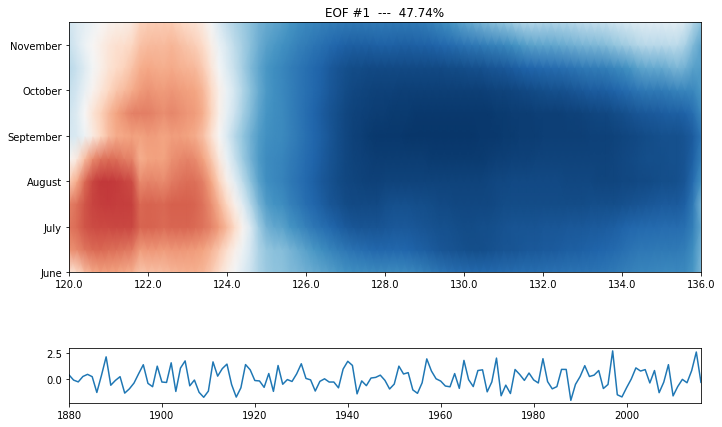

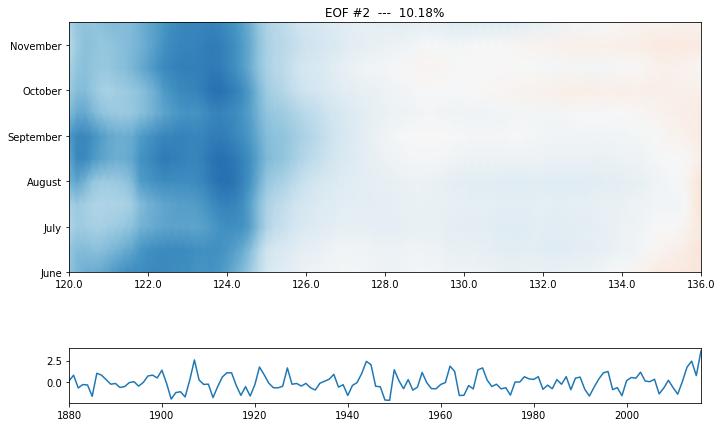

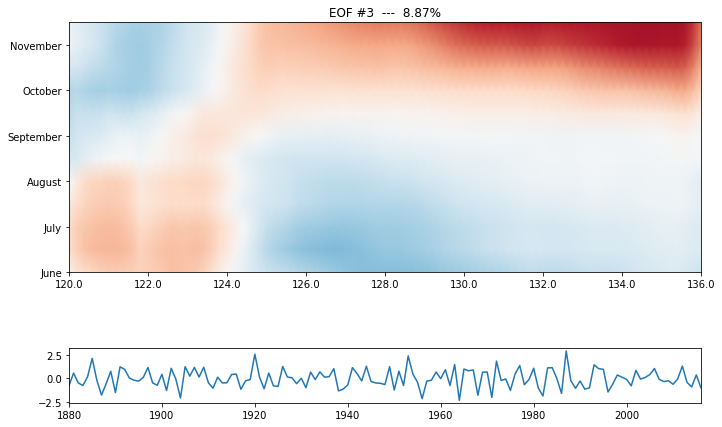

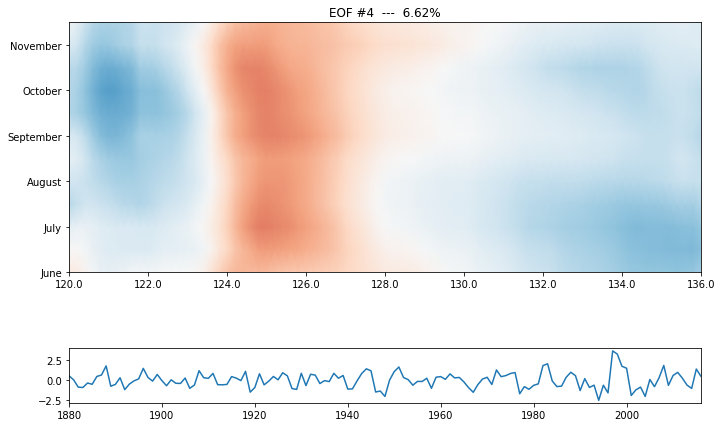

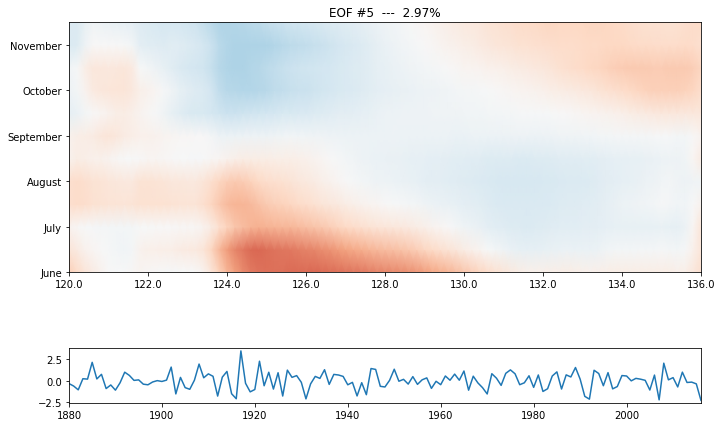

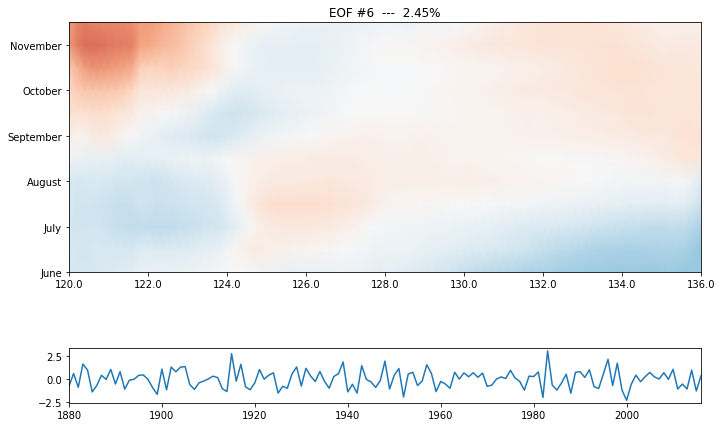

In [5]:
# plot EOFs
n_plot = 6
PlotEOFs(xds_PCA, n_plot)


In [6]:
# --------------------------------------
# KMA Classification 

xds_AWT = KMA_simple(xds_PCA, num_clusters, repres)
print(xds_AWT)

# Set PCA and KMA dates (annual array)
dates_fit = [datetime(y, pca_month_ini, 1) for y in range(pca_year_ini, pca_year_end+1)]
xds_PCA['time']=(('n_components'), dates_fit)
xds_AWT['time']=(('n_pcacomp'), dates_fit)

# store SST AWTs and PCs
db.Save_SST_PCA(xds_PCA)
db.Save_SST_KMA(xds_AWT)


<xarray.Dataset>
Dimensions:         (n_clusters: 6, n_features: 28, n_pcacomp: 137, n_pcafeat: 972)
Dimensions without coordinates: n_clusters, n_features, n_pcacomp, n_pcafeat
Data variables:
    order           (n_clusters) int64 4 5 1 0 3 2
    bmus_corrected  (n_pcacomp) int64 2 3 2 2 2 3 4 2 0 3 ... 3 1 4 4 3 5 1 0 5
    cenEOFs         (n_clusters, n_features) float64 -6.223 -1.374 ... 0.2757
    bmus            (n_pcacomp) int32 1 0 1 1 1 0 3 1 4 0 ... 0 5 3 3 0 2 5 4 2
    centroids       (n_clusters, n_pcafeat) float64 -0.2439 -0.3067 ... -0.142
    Km              (n_clusters, n_pcafeat) float64 -0.03941 ... -0.1209
    group_size      (n_clusters) int64 28 26 19 28 18 18
    PCs             (n_pcacomp, n_features) float64 7.972 1.668 ... -0.06965
    variance        (n_pcacomp) float64 467.5 99.72 86.87 ... 4.251e-05 9.22e-29


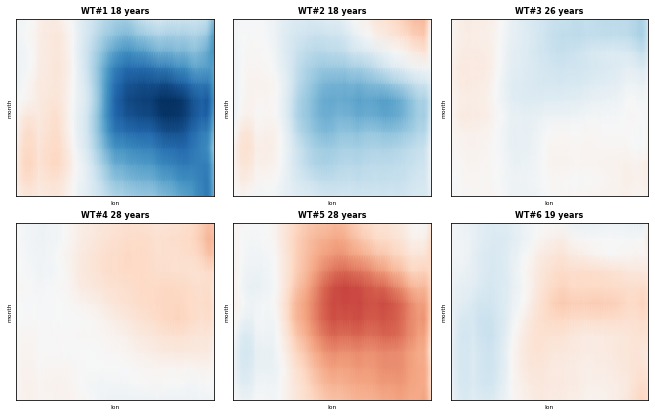

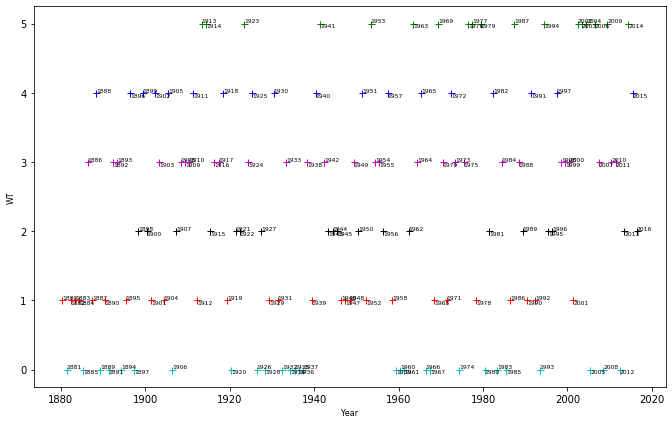

In [7]:
# Plot Weather Types
Plot_Weather_Types(xds_AWT, xds_PCA.pred_lon)

# Plot year/label WTs
Plot_WTs_Dates(xds_AWT)


In [8]:
# --------------------------------------
# PCs123 random generation with Copulas

kma_order = xds_AWT.order.values
kma_labels = xds_AWT.bmus.values

# Get bmus Persistences
d_pers_bmus = Persistences(xds_AWT.bmus.values)

# first 3 PCs
PCs = xds_AWT.PCs.values
variance = xds_AWT.variance.values
PC1 = np.divide(PCs[:,0], np.sqrt(variance[0]))
PC2 = np.divide(PCs[:,1], np.sqrt(variance[1]))
PC3 = np.divide(PCs[:,2], np.sqrt(variance[2]))

# for each WT: generate copulas and simulate data 
d_pcs_fit = {}
d_pcs_rnd = {}
for i in range(num_clusters):

    # getting copula number from plotting order
    num = kma_order[i]

    # find all the best match units equal
    ind = np.where(kma_labels == num)[:]

    # PCs for weather type
    PC123 = np.column_stack((PC1[ind], PC2[ind], PC3[ind]))
    
    # statistical simulate PCs using copulas with KDE (kernel density estimation)
    kernels = ['KDE', 'KDE', 'KDE']
    PC123_rnd = CopulaSimulation(PC123, kernels, num_PCs_rnd)

    # store data 
    d_pcs_fit['WT #{0}'.format(num+1)] = PC123
    d_pcs_rnd['WT #{0}'.format(num+1)] = PC123_rnd
    

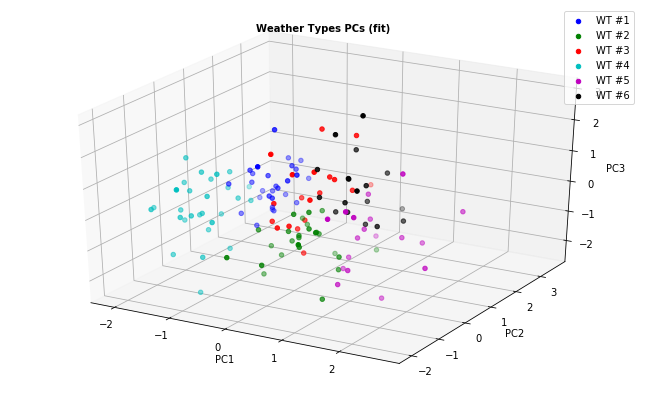

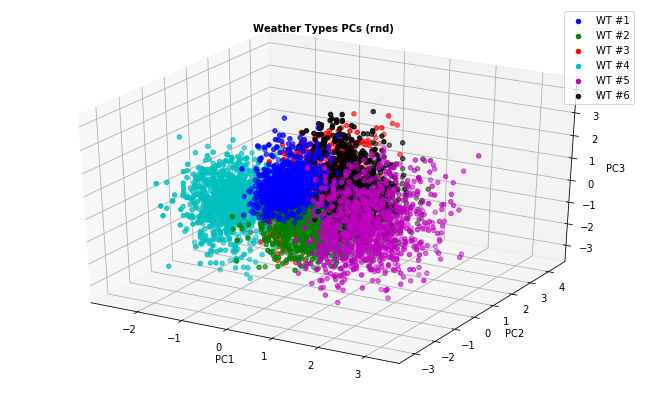

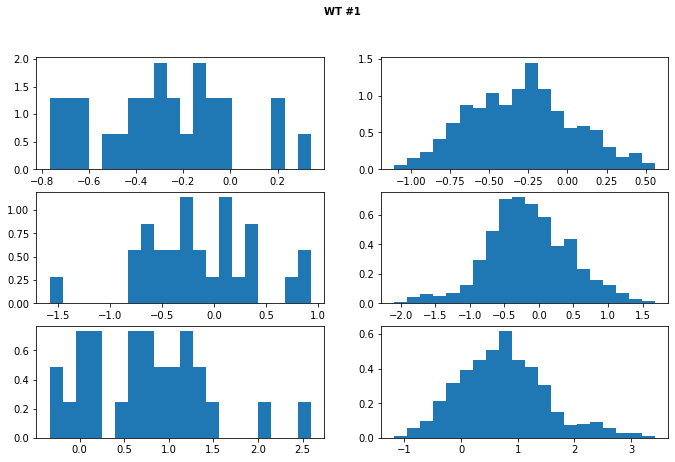

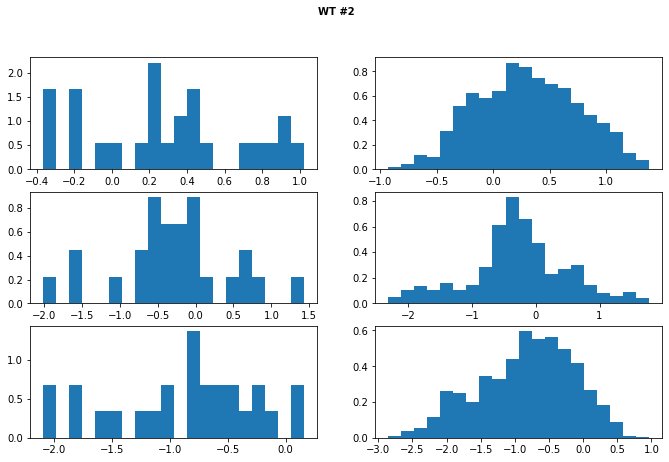

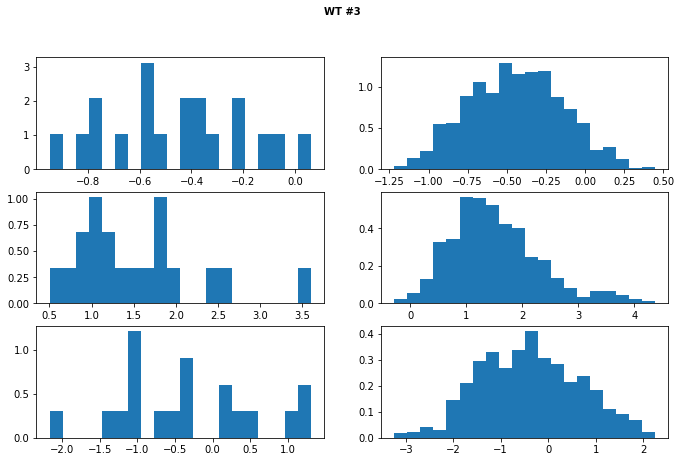

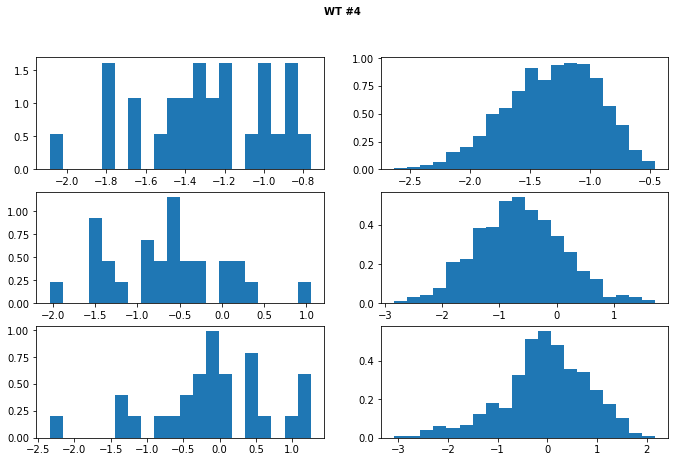

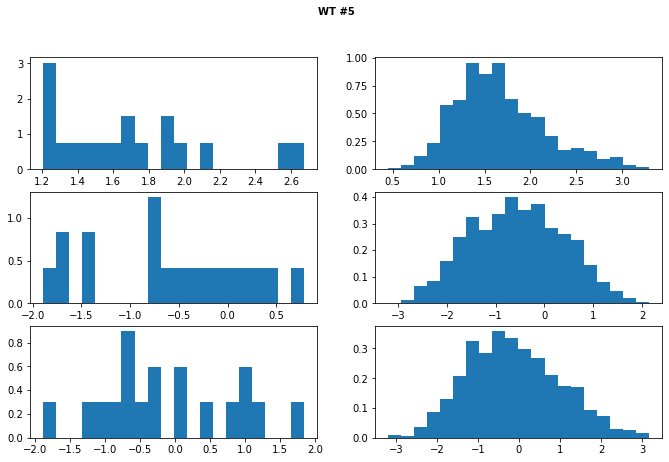

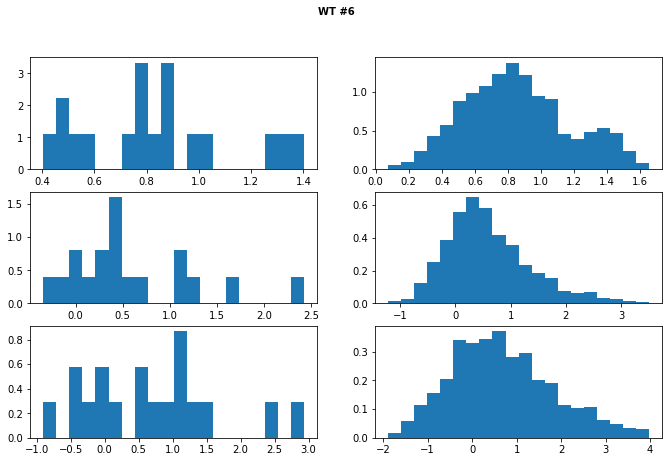

In [9]:
# Plot Weather Type 3D PCs for fit and random generation data
Plot_3D_3PCs_WTs(d_pcs_fit, 'Weather Types PCs (fit)')
Plot_3D_3PCs_WTs(d_pcs_rnd, 'Weather Types PCs (rnd)')

# Plot Weather Type histogram comparison for fit and random generation data
Plot_Compare_WTs_hist(d_pcs_fit, d_pcs_rnd)


In [10]:
# --------------------------------------
# Autoregressive Logistic Regression - fit model

xds_bmus_fit = xr.Dataset(
    {
        'bmus':(('time',), xds_AWT.bmus),
    },
    coords = {'time': xds_AWT.time.values}
)

# ALR terms
d_terms_settings = {
    'mk_order'  : 1,
    'constant' : True,
    'long_term' : False,
    'seasonality': (False, []),
}

# ALR wrapper
ALRW = ALR_WRP(db.paths.site.SST.alrw)
ALRW.SetFitData(num_clusters, xds_bmus_fit, d_terms_settings)

# ALR model fitting
ALRW.FitModel(max_iter=50000)



Fitting autoregressive logistic model ...
Optimization done in 0.07 seconds



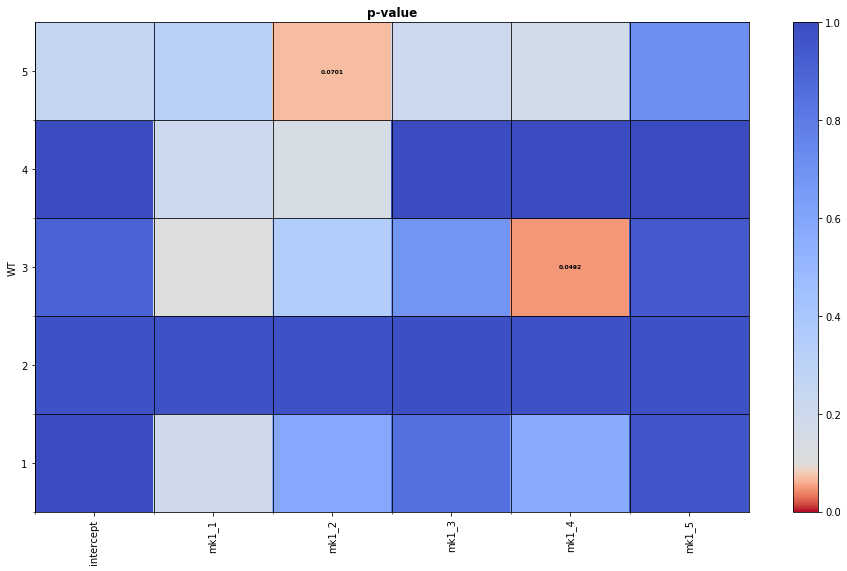

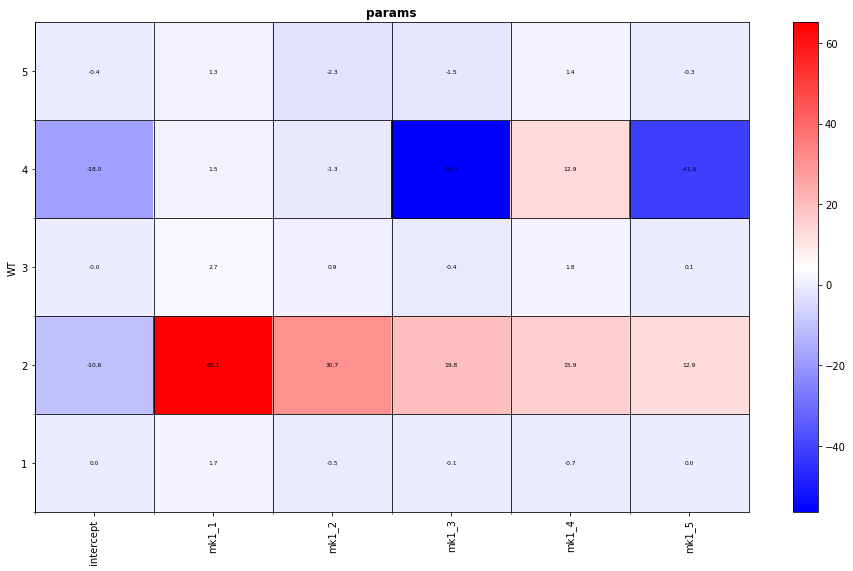

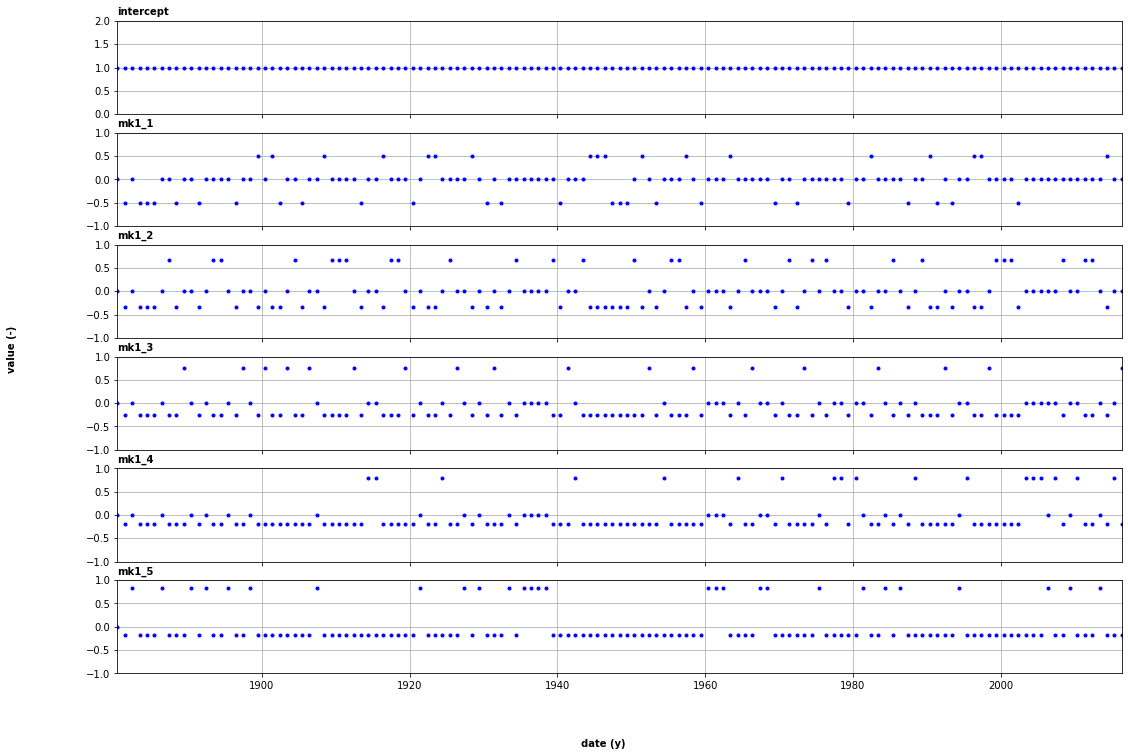

                          MNLogit Regression Results                          
Dep. Variable:                   bmus   No. Observations:                  137
Model:                        MNLogit   Df Residuals:                      107
Method:                           MLE   Df Model:                           25
Date:                Mon, 09 Sep 2019   Pseudo R-squ.:                  0.1194
Time:                        22:46:06   Log-Likelihood:                -213.74
converged:                       True   LL-Null:                       -242.73
                                        LLR p-value:                 0.0001981
    bmus=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.338      0.004      0.997      -0.662       0.664
mk1_1          1.7085      1.323      1.291      0.197      -0.885       4.301
mk1_2         -0.4816      0.895     -0.538      0.5

In [11]:
# show fit report
ALRW.Report_Fit(terms_fit=True, summary=True)


In [12]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate 

# simulation dates (annual array)
dates_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim, y2_sim+1)]

# launch simulation
xds_alr = ALRW.Simulate(num_ALR_sims, dates_sim)
evbmus_sim = np.squeeze(xds_alr.evbmus_sims.values[:])

evbmus_sim[np.where(evbmus_sim==0)]=1  # TODO: fix ALR bug, first evbmus_sim value is a 0 (has to be 1-6)

# Generate random PCs
pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
for c, m in enumerate(evbmus_sim):
    options = d_pcs_rnd['WT #{0}'.format(int(m))]
    r = np.random.randint(options.shape[0])
    pcs123_sim[c,:] = options[r,:]

# denormalize simulated PCs
PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(variance[0]))
PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(variance[1]))
PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(variance[2]))

# store simulated PCs
xds_PCs_sim = xr.Dataset(
    {
        'PC1'  :(('time',), PC1_sim),
        'PC2'  :(('time',), PC2_sim),
        'PC3'  :(('time',), PC3_sim),
    },
    {'time' : dates_sim}
)
print(xds_PCs_sim)

db.Save_SST_PCs_sim(xds_PCs_sim)


ALR model fit   : 1880-06-01T00:00:00.000000000 --- 2016-06-01T00:00:00.000000000
ALR model sim   : 2020-06-01 00:00:00 --- 3020-06-01 00:00:00

Launching 1 simulations...

<xarray.Dataset>
Dimensions:  (time: 1001)
Coordinates:
  * time     (time) object 2020-06-01 2021-06-01 ... 3019-06-01 3020-06-01
Data variables:
    PC1      (time) float64 -16.78 -20.88 14.5 -3.729 ... -29.5 -36.19 4.305
    PC2      (time) float64 4.869 -5.886 -2.302 10.56 ... 5.386 -0.8857 -2.757
    PC3      (time) float64 -2.592 -19.83 -15.75 -11.48 ... 11.56 15.3 6.233


In [13]:
# show simulation report
#ALRW.Report_Sim()
